In [1]:
#dataset=https://www.kaggle.com/datasets/camnugent/california-housing-prices/data
import pandas as pd
data = pd.read_csv('./housing.csv')

data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [2]:
data.isnull().sum()
data = data.dropna() 

In [3]:
data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [4]:
import pymc as pm
import numpy as np

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [7]:
X = data.drop(columns=['median_house_value', 'ocean_proximity']) 
y = data['median_house_value']

In [8]:
X_data = X.values
y_data = y.values

In [15]:
X_data_subsample = X_data[:1000]
y_data_subsample = y_data[:1000]

In [27]:
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(X_data_subsample.shape[1],))
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = pm.math.dot(X_data_subsample, betas)
    y_obs = pm.Normal('y', mu=mu, sigma=sigma, observed=y_data_subsample)
    trace = pm.sample(500,chains=4,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 67 seconds.


array([[<Axes: title={'center': 'betas'}>,
        <Axes: title={'center': 'betas'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

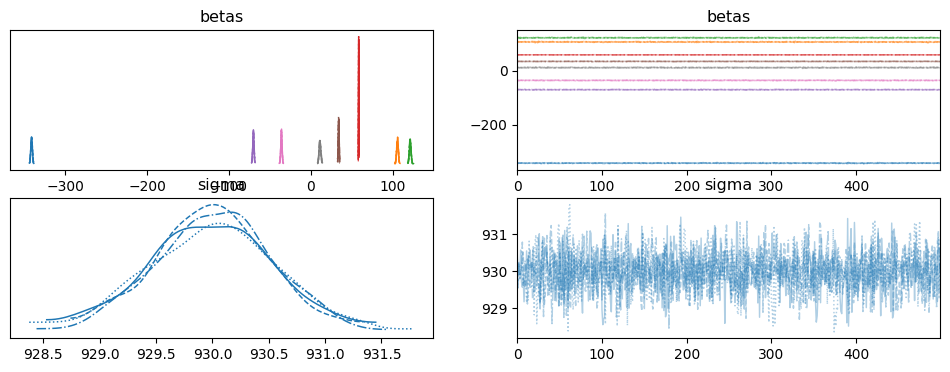

In [28]:
import arviz as az
az.plot_trace(trace)

In [19]:
posterior_betas = trace.posterior['betas']
posterior_betas.mean(dim=('chain', 'draw')), posterior_betas.std(dim=('chain', 'draw'))

(<xarray.DataArray 'betas' (betas_dim_0: 8)>
 array([-340.77461114,  105.51512873,  120.92379241,   58.15504176,
         -70.29647698,   33.72971297,  -36.04985936,   10.96910203])
 Coordinates:
   * betas_dim_0  (betas_dim_0) int32 0 1 2 3 4 5 6 7,
 <xarray.DataArray 'betas' (betas_dim_0: 8)>
 array([0.84536131, 0.96781133, 0.98046885, 0.19159841, 0.72935061,
        0.4763509 , 0.76379514, 1.01801921])
 Coordinates:
   * betas_dim_0  (betas_dim_0) int32 0 1 2 3 4 5 6 7)

In [20]:
import matplotlib.pyplot as plt

In [35]:
posterior_betas = trace.posterior['betas'].mean(dim=('chain', 'draw'))
posterior_sigma = trace.posterior['sigma'].mean(dim=('chain', 'draw'))
print(f"Posterior Mean of Betas:\n{posterior_betas}")
print(f"Posterior Mean of Sigma:\n{posterior_sigma}")

Posterior Mean of Betas:
<xarray.DataArray 'betas' (betas_dim_0: 8)>
array([-340.73992113,  105.46637262,  120.90318797,   58.15272476,
        -70.26584705,   33.73867478,  -36.07798214,   10.95232081])
Coordinates:
  * betas_dim_0  (betas_dim_0) int32 0 1 2 3 4 5 6 7
Posterior Mean of Sigma:
<xarray.DataArray 'sigma' ()>
array(929.99488427)


Gelman-Rubin Diagnostic (R-hat):
<xarray.Dataset>
Dimensions:      (betas_dim_0: 8)
Coordinates:
  * betas_dim_0  (betas_dim_0) int32 0 1 2 3 4 5 6 7
Data variables:
    betas        (betas_dim_0) float64 1.002 1.004 1.002 ... 1.001 1.001 1.001
    sigma        float64 1.004
Effective Sample Size (ESS):
<xarray.Dataset>
Dimensions:      (betas_dim_0: 8)
Coordinates:
  * betas_dim_0  (betas_dim_0) int32 0 1 2 3 4 5 6 7
Data variables:
    betas        (betas_dim_0) float64 2.037e+03 2.146e+03 ... 2.573e+03
    sigma        float64 2.372e+03
MCMC sampling has converged successfully!


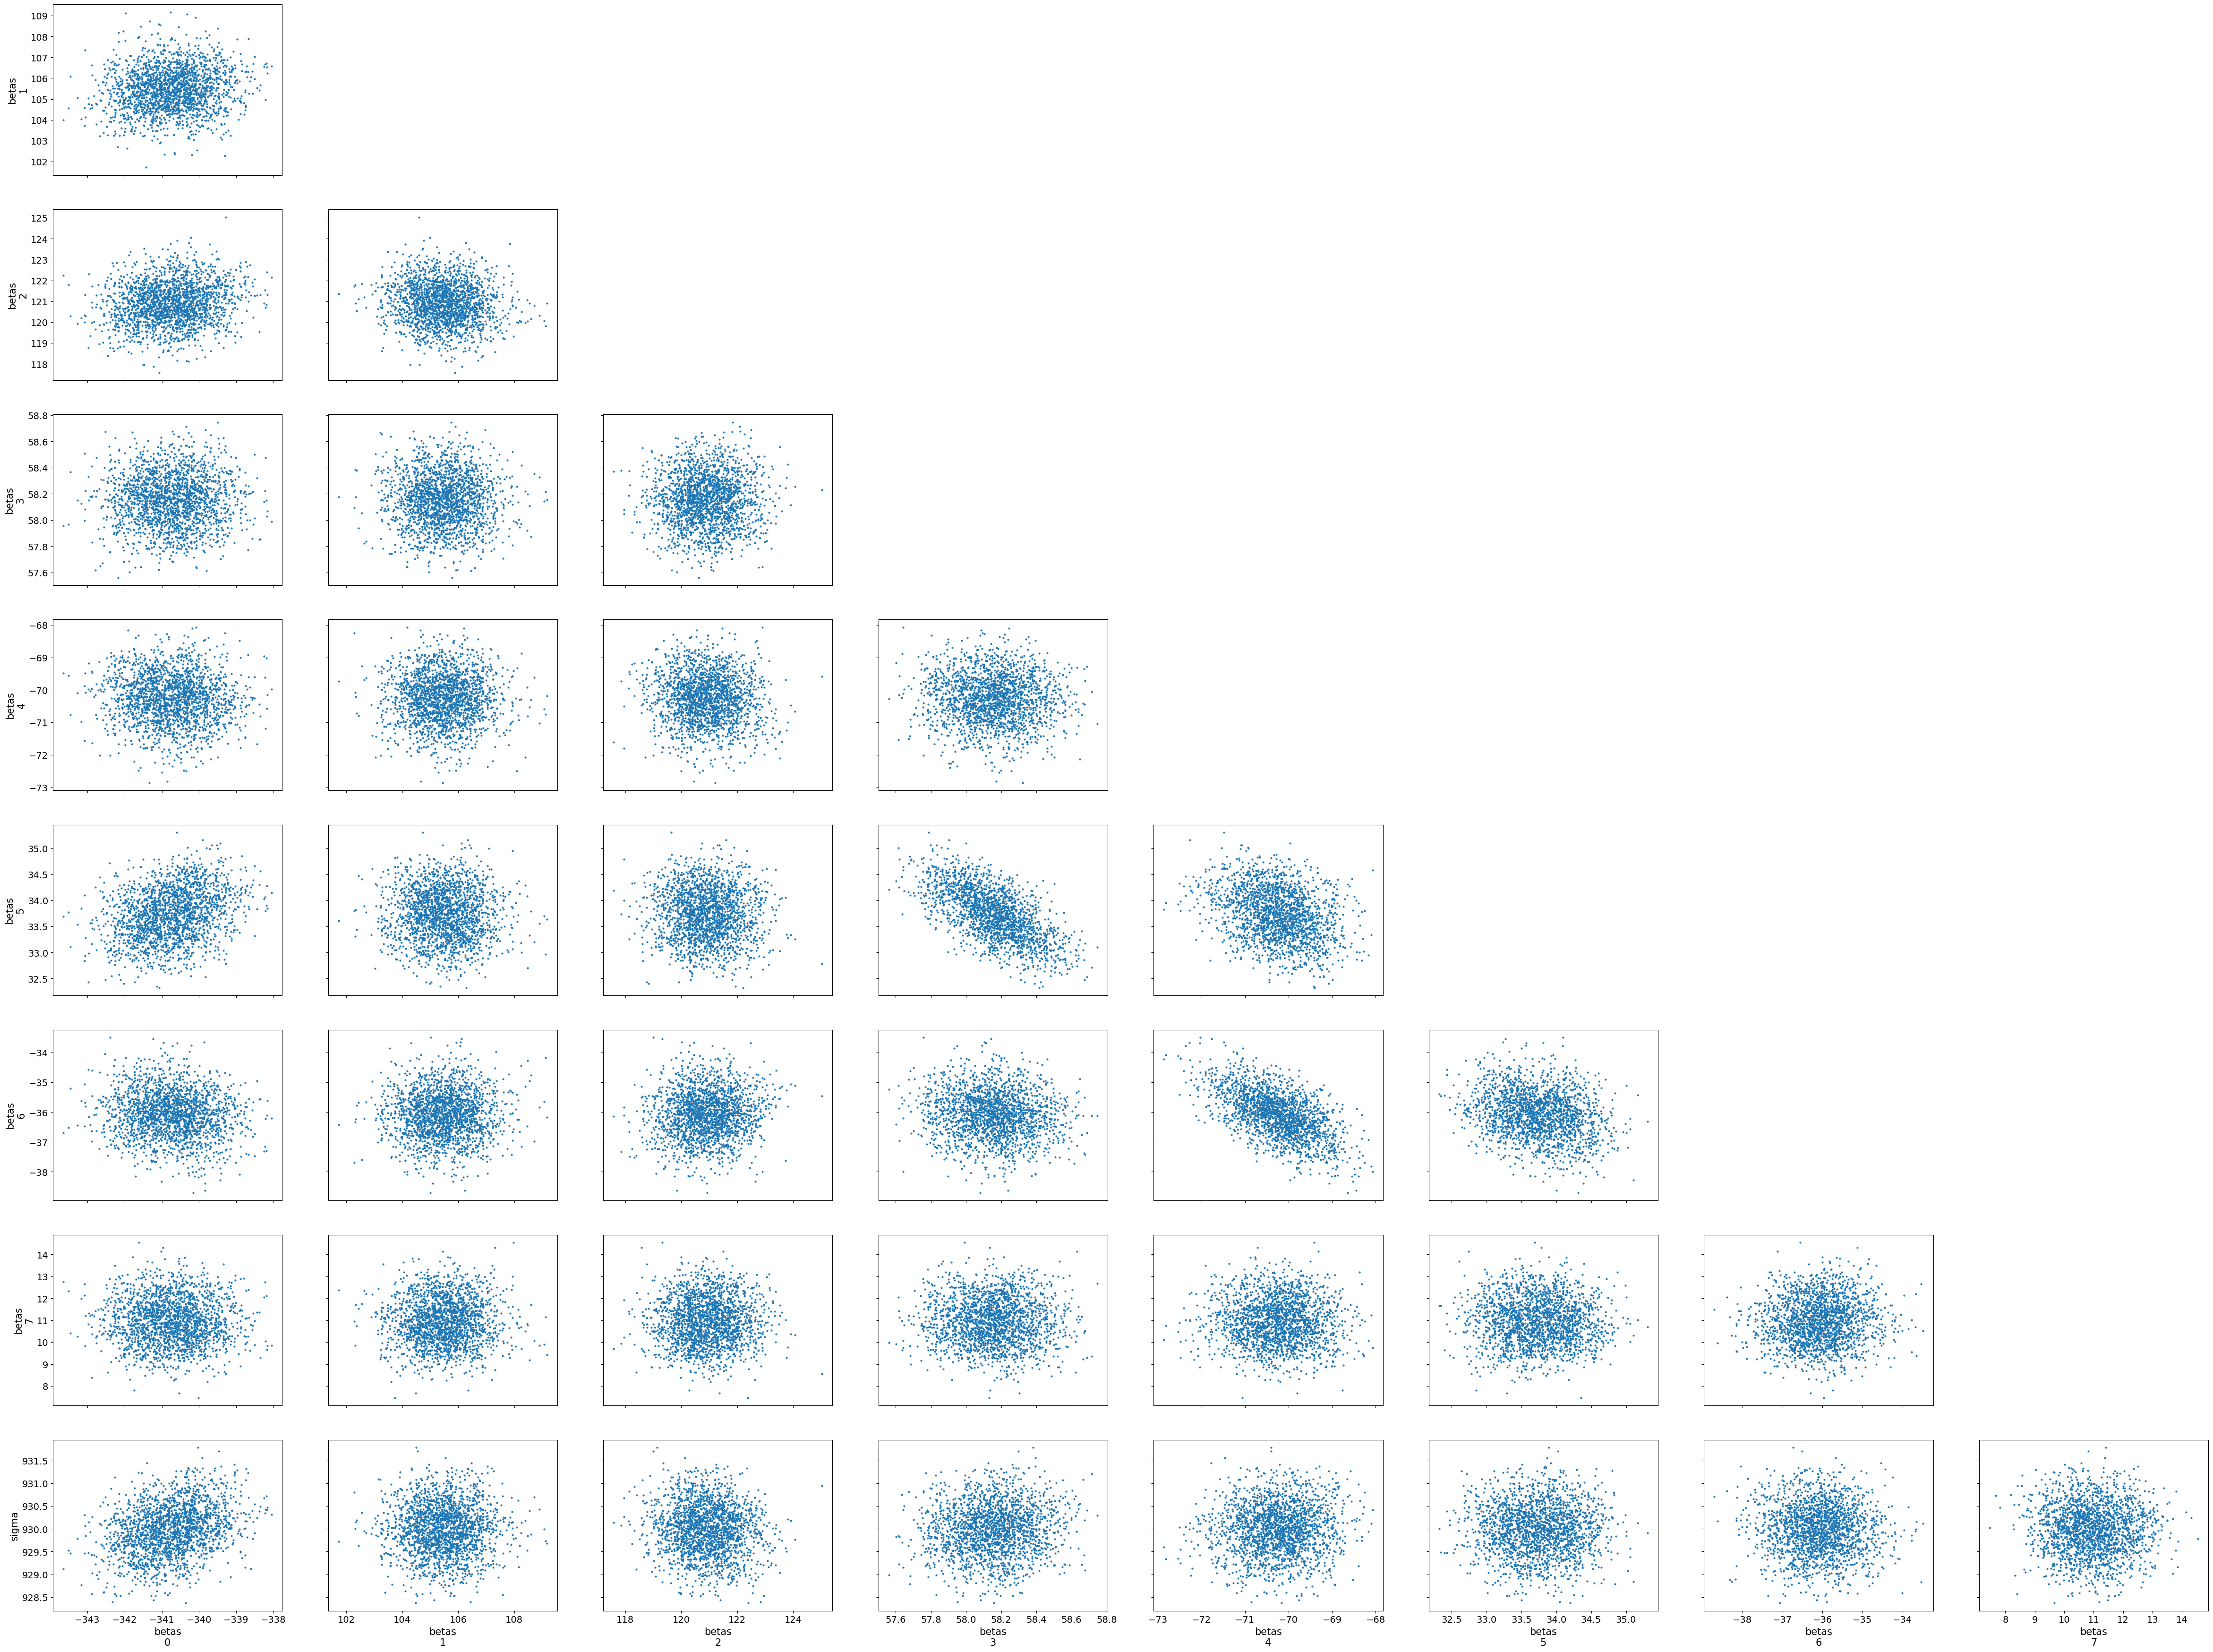

In [36]:
rhat = az.rhat(trace)
print(f"Gelman-Rubin Diagnostic (R-hat):\n{rhat}")
ess = az.ess(trace)
print(f"Effective Sample Size (ESS):\n{ess}")
if np.all(rhat < 1.1) and np.all(ess > 100):
    print("MCMC sampling has converged successfully!")
else:
    print("MCMC sampling may not have converged.")
az.plot_pair(trace, var_names=["betas", "sigma"])
plt.show()